In [173]:
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools


import warnings
warnings.filterwarnings('ignore')

            Passengers
date                  
31/01/1949         112
28/02/1949         118
31/03/1949         132
30/04/1949         129
31/05/1949         121
...                ...
31/08/1960         606
30/09/1960         508
31/10/1960         461
30/11/1960         390
31/12/1960         432

[144 rows x 1 columns]


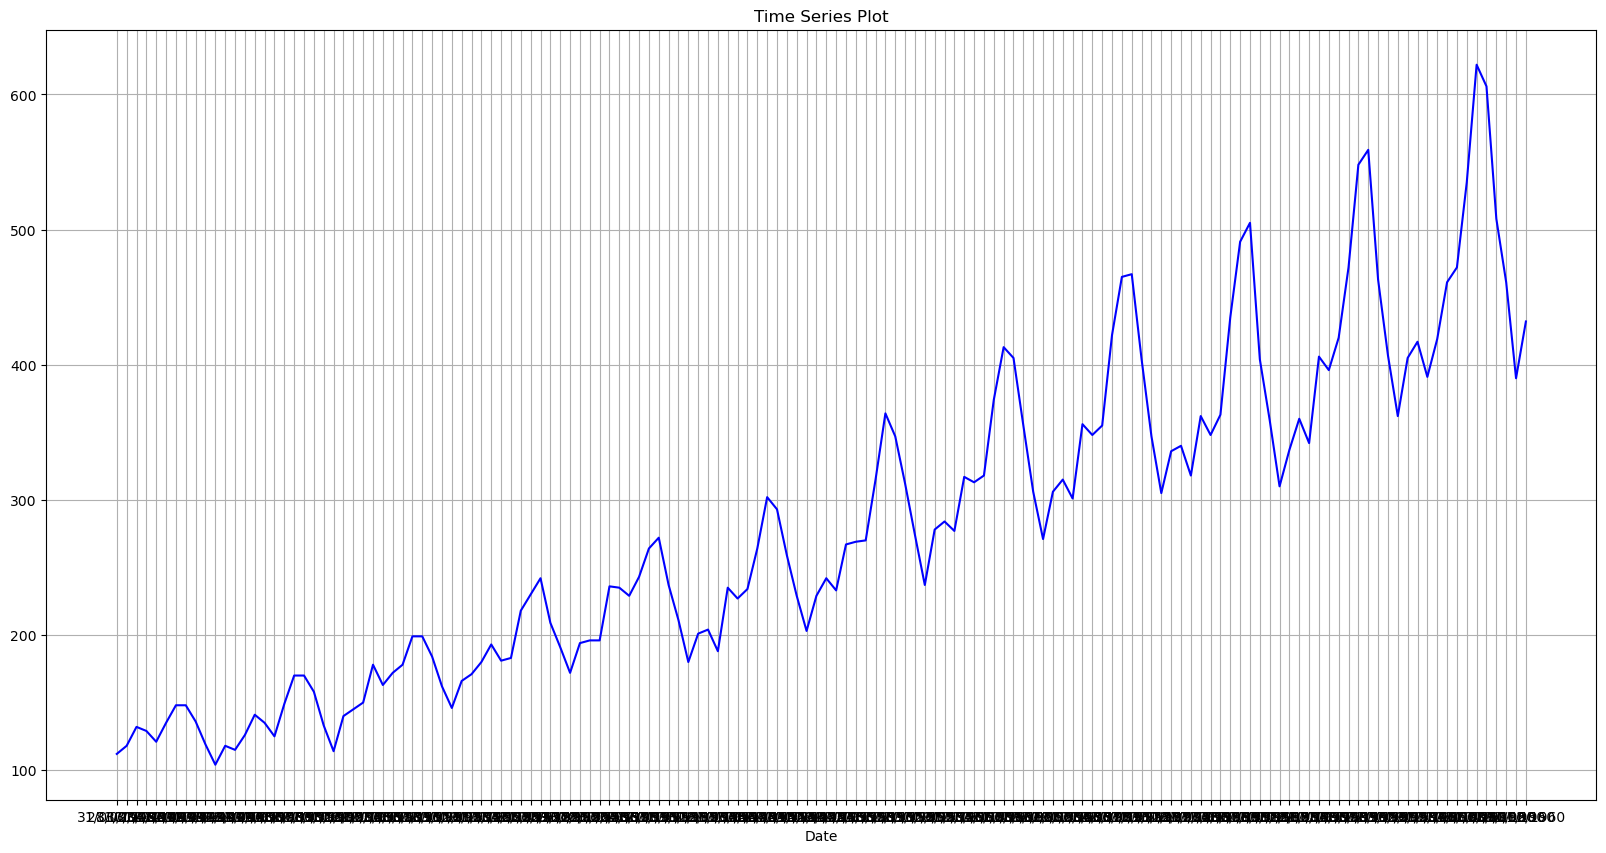

Index(['Passengers'], dtype='object')


In [174]:
df = pd.read_csv('air-passengers.csv')


df.set_index('date', inplace=True)
print(df)

plt.figure(figsize=(20, 10))
plt.plot(df, linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.grid(True)
plt.show()

print(df.columns)

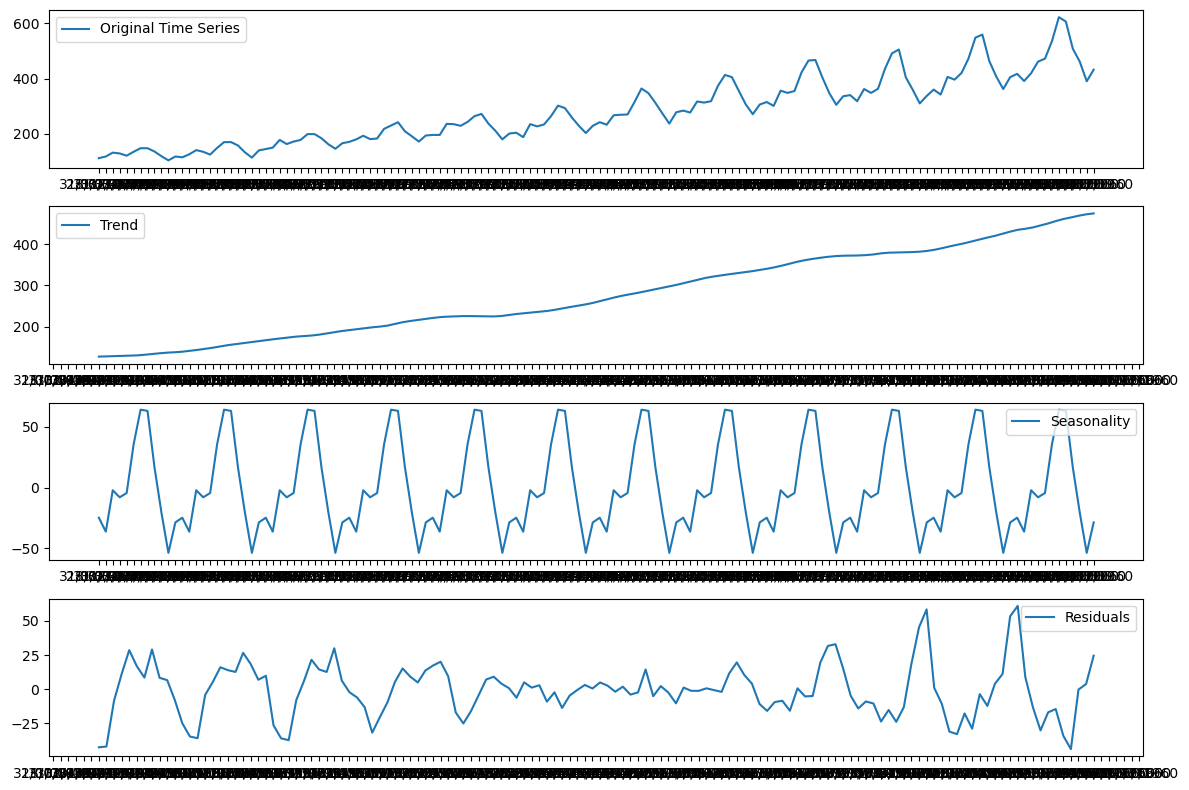

In [175]:
#ex3 - Use Time series Decomposition (Additive)
components = seasonal_decompose(df['Passengers'], model='additive', period=12)
# Plot the decomposition results
plt.figure(figsize=(12, 8))

# Original time series
plt.subplot(411)
plt.plot(df['Passengers'], label='Original Time Series')
plt.legend()

# Trend component
plt.subplot(412)
plt.plot(components.trend, label='Trend')
plt.legend()

# Seasonal component
plt.subplot(413)
plt.plot(components.seasonal, label='Seasonality')
plt.legend()

# Residuals component
plt.subplot(414)
plt.plot(components.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

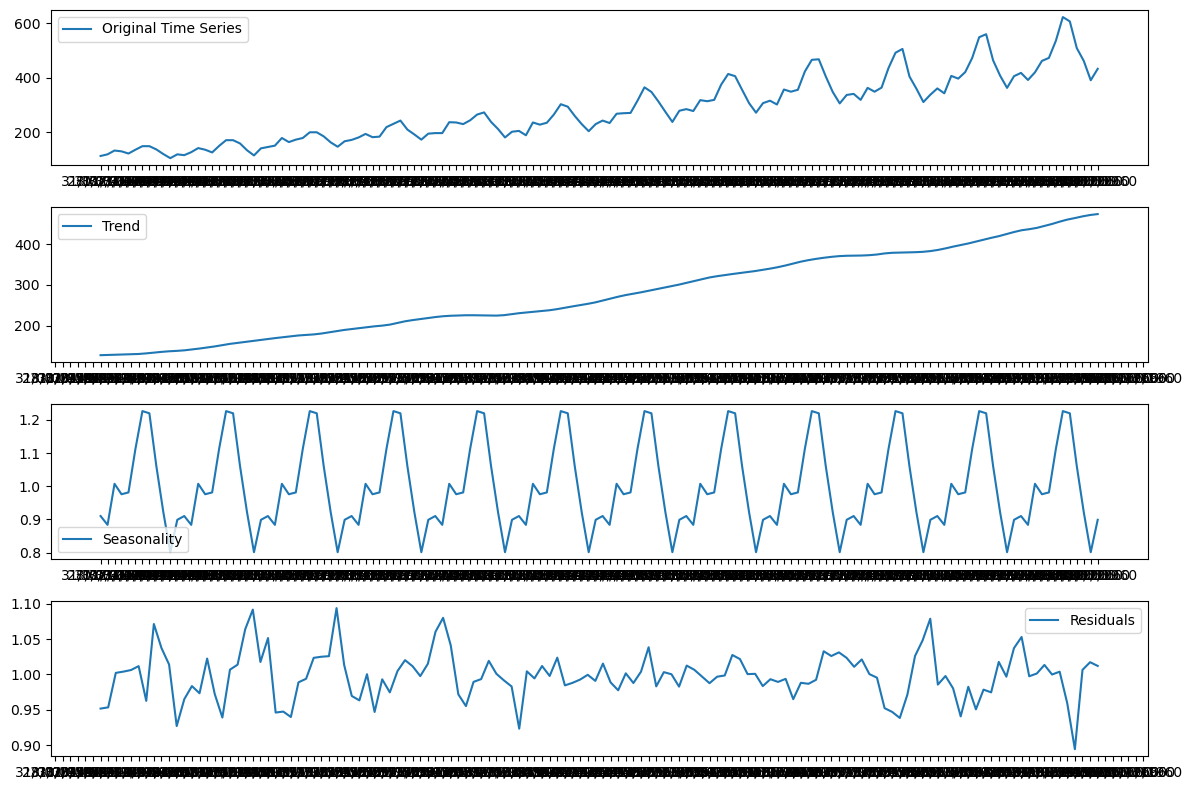

In [176]:
#ex3 - Use Time series Decomposition (Multiplicative)
components = seasonal_decompose(df['Passengers'], model='multiplicative', period=12)
# Plot the decomposition results
plt.figure(figsize=(12, 8))

# Original time series
plt.subplot(411)
plt.plot(df['Passengers'], label='Original Time Series')
plt.legend()

# Trend component
plt.subplot(412)
plt.plot(components.trend, label='Trend')
plt.legend()

# Seasonal component
plt.subplot(413)
plt.plot(components.seasonal, label='Seasonality')
plt.legend()

# Residuals component
plt.subplot(414)
plt.plot(components.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

## ex4 - Based on your exploration, determine the most suitable model

### The most suitable model is SARIMA, as the time series decomposotion shows seasonal aspects (repeating patterns)

In [177]:
#Ex5 - let's make the series stationary if it isn't already
ADF_result = adfuller(df)

print(f"ADF Statistic: {round(ADF_result[0], 3)}")
print(f"p-value: {round(ADF_result[1], 3)}")

if round(ADF_result[1], 3) < 0.05:
    print('Time Series is Stationary!')
else:
    print('Time Series is not Stationary!')

ADF Statistic: 0.815
p-value: 0.992
Time Series is not Stationary!


In [178]:
#ex5 - a) it's not stationary, so let's make it

df_diff = df.diff().iloc[1:]
ADF_result = adfuller(df_diff)
d = 1
D = 0
while (round(ADF_result[1], 3) >= 0.05):
    df_diff = df_diff.diff().iloc[1:]
    ADF_result = adfuller(df_diff)
    d = d+1
    if (round(ADF_result[1], 3) < 0.05):
        print(f"ADF Statistic: {round(ADF_result[0], 3)}")
        print(f"p-value: {round(ADF_result[1], 3)}")
        break

print("Time series is now stationary!")
print(f"Number of times it had to be differenced to become stationary: {d}")

ADF Statistic: -16.384
p-value: 0.0
Time series is now stationary!
Number of times it had to be differenced to become stationary: 2


In [179]:
#lets also test season differencing
df_diff = df.diff(12).dropna()
ADF_result = adfuller(df_diff)
D = 1
d = 0
print(round(ADF_result[1], 3))
while (round(ADF_result[1], 3) >= 0.05):
    df_diff = df_diff.diff(12).iloc[1:]
    ADF_result = adfuller(df_diff)
    D = D+1
    print(round(ADF_result[1], 3))
    if (round(ADF_result[1], 3) < 0.05):
        print(f"ADF Statistic: {round(ADF_result[0], 3)}")
        print(f"p-value: {round(ADF_result[1], 3)}")
        break

print("Time series is now stationary!")
print(f"Number of times it had to be seasonaly differenced to become stationary: {D}")


0.012
Time series is now stationary!
Number of times it had to be seasonaly differenced to become stationary: 1


In [180]:
# d = 1
# D = 1
print(d)
print(D)
m = 12

0
1


In [181]:
#ex5 - b)
df_train = df_diff.iloc[:-12]
df_test = df_diff.iloc[-12:]


# autocorrelation functions
# c. Find the optimal (p , q) parameters.

def generate_order_list(x, y):
    # Generate all combinations of p, d, q, and s within the specified range
    orders = list(itertools.product(range(x, y + 1), repeat=4))

    return orders


def optimize_SARIMA(data, order_list) -> pd.DataFrame:
    results = []

    for order in order_list:
        try:
            model = SARIMAX(data, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], m), simple_differencing=False)

        except:
            continue

        
        aic = model.fit(disp=False, maxiter=1000, method='powell').aic
        results.append([order[0], order[1], order[2], order[3], aic])

    result_df = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


best_aic = optimize_SARIMA(df_train, generate_order_list(1, 3))

print(best_aic)



    p  q  P  Q         AIC
0   1  1  1  1  829.931117
1   2  1  1  1  830.095779
2   1  2  1  1  830.795048
3   1  1  2  1  831.436829
4   1  3  1  1  831.605346
.. .. .. .. ..         ...
76  3  2  2  2  836.840727
77  2  3  1  2  836.878559
78  3  2  1  2  837.302700
79  2  3  3  3  837.719311
80  3  2  3  3  837.978261

[81 rows x 5 columns]


In [182]:
#ex5 - d


# print(best_aic['p'].iloc[0])
# print(best_aic['q'].iloc[0])
# print(best_aic['P'].iloc[0])
# print(best_aic['Q'].iloc[0])
p = best_aic['p'].iloc[0]
q = best_aic['q'].iloc[0]
P = best_aic['P'].iloc[0]
Q = best_aic['Q'].iloc[0]


#let's fit the model with the optimal parameters
model = sm.tsa.SARIMAX(df_train, order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit(disp=False, method='powell')

# Print model summary
print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -409.966
Date:                            Sun, 17 Dec 2023   AIC                            829.931
Time:                                    04:42:31   BIC                            843.342
Sample:                                01-31-1950   HQIC                           835.369
                                     - 12-31-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9439      0.058     16.302      0.000       0.830       1.057
ma.L1         -0.3155      0.091   

count    10.000000
mean      0.129855
std       0.075993
min       0.053935
25%       0.086674
50%       0.115483
75%       0.146010
max       0.320816
Name: lb_pvalue, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1200x400 with 0 Axes>

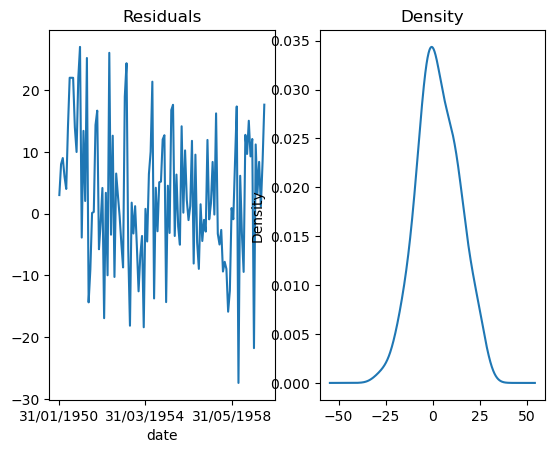

In [183]:
#ex5 - Perform residual analysis

# e. Perform the residual analysis to validate if the model can be used to forecast.
residuals = model_fit.resid

residuals_test = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(residuals_test['lb_pvalue'].describe())


plt.figure(figsize=(12, 4))
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(title="Density", kind='kde', ax=ax[1])
plt.show

In [184]:
from statsmodels.tsa.arima.model import ARIMA

# Define ranges for p, d, q
p_values = range(3)
d_values = range(3)
q_values = range(3)

# Generate all combinations of p, d, q
parameter_combinations = list(itertools.product(p_values, d_values, q_values))

# Fit ARIMA models and store AIC for each combination
aic_results_arima = []

for params in parameter_combinations:
    try:
        model_arima = ARIMA(df_train, order=(params[0], params[1], params[2]))
        results_arima = model_arima.fit()
        aic_results_arima.append((params, results_arima.aic))
    except:
        continue

# Find the combination with the lowest AIC for ARIMA
best_params_arima = min(aic_results_arima, key=lambda x: x[1])
print("Best ARIMA Model Parameters:", best_params_arima[0])

Best ARIMA Model Parameters: (1, 1, 0)


In [185]:
#ex6 - Predict a full year of monthly number of air passengers using the last 12 months of data as test set.



def rolling_forecast(function: str, df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    if (function.lower() == 'sarima'):
        total_len = train_len + horizon
        pred_SARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(p,d,q), seasonal_order=(P, D, Q, m))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA
    
    elif (function.lower() == 'arima'):
        total_len = train_len + horizon
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA
    
    elif function.lower() == 'mean':
        pred_mean = []

        for i in range(train_len, len(df), window):
            mean_value = df[i - window:i].mean()  # Replace 'your_column_name' with the actual column name
            pred_mean.extend([mean_value] * window)

        return pred_mean[:horizon]  # Use 'horizon' instead of a fixed value like 168

    elif function.lower() == 'last':
        pred_last = []

        for i in range(train_len, len(df), window):
            last_value = df[i - 1:i].iloc[-1]  # Replace 'your_column_name' with the actual column name
            pred_last.extend([last_value] * window)

        return pred_last[:horizon]  # Use 'horizon' instead of a fixed value like 168

In [186]:
pred_SARIMA = rolling_forecast('sarima', df_diff, len(df_train), len(df_test), 1)

pred_mean = rolling_forecast('mean', df_diff, len(df_train), len(df_test), 1)


pred_arima = rolling_forecast('arima', df_diff, len(df_train), len(df_test), 1)


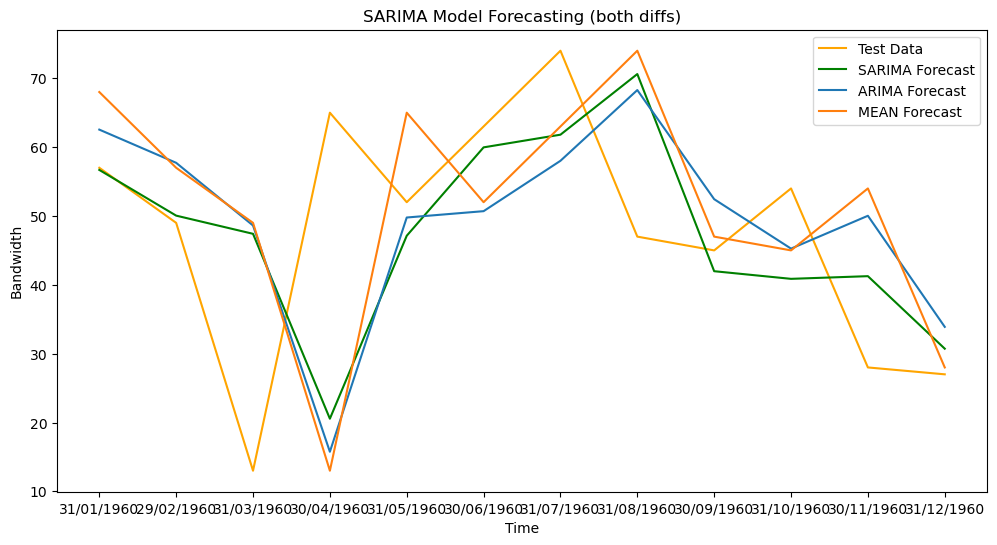

In [187]:
# Plot the training data, test data, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_test, label='Test Data', color='orange')
plt.plot(df_test.index, pred_SARIMA, label='SARIMA Forecast', color='green')
plt.plot(df_test.index, pred_arima, label='ARIMA Forecast')
plt.plot(df_test.index, pred_mean, label='MEAN Forecast')


plt.title('SARIMA Model Forecasting (both diffs)')
plt.xlabel('Time')
plt.ylabel('Bandwidth')
plt.legend()
plt.show()

In [188]:
# Assuming df_test is your test set and actual_values is the actual passenger counts
actual_values = df_test['Passengers'].values

# Calculate MAE for SARIMA model
mae_sarima = mean_absolute_error(actual_values, pred_SARIMA)

# Calculate MAE for ARIMA model
mae_arima = mean_absolute_error(actual_values, pred_arima)

# Calculate MAE for mean baseline model
mae_mean = mean_absolute_error(actual_values, pred_mean)

# Print results
print("MAE for SARIMA:", mae_sarima)
print("MAE for ARIMA:", mae_arima)
print("MAE for Mean Baseline:", mae_mean)

# Calculate MAPE for SARIMA model
mape_sarima = np.mean(np.abs((actual_values - pred_SARIMA) / actual_values)) * 100

# Calculate MAPE for ARIMA model
mape_arima = np.mean(np.abs((actual_values - pred_arima) / actual_values)) * 100

# Calculate MAPE for mean baseline model
mape_mean = np.mean(np.abs((actual_values - pred_mean) / actual_values)) * 100

# Print results
print("MAPE for SARIMA:", mape_sarima)
print("MAPE for ARIMA:", mape_arima)
print("MAPE for Mean Baseline:", mape_mean)

MAE for SARIMA: 13.088942145580297
MAE for ARIMA: 16.335057160120105
MAE for Mean Baseline: 17.25
MAPE for SARIMA: 42.402548982495034
MAPE for ARIMA: 50.4057481328953
MAPE for Mean Baseline: 59.85444991598451
